In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from networks.matrix_neural_net import NeuralNetwork
from network_manager import NetworkManager
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

class TqdmUpdate(tqdm):
     def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# load images and labels of the MNIST data set 
# each element in x_train/x_test is a handwritten digit
# and each element in y_train/y_test is the associated 
# label for that digit (0-9)
if not os.path.exists('./data/mnist/X.npy'):
    import mnist
    x_train, y_train = mnist.train_images(), mnist.train_labels()
    x_test, y_test = mnist.test_images(), mnist.test_labels()
    X = np.append(x_train, x_test)
    y = np.append(y_train, y_test)
#     np.save('./data/mnist/X', X)
#     np.save('./data/mnist/y', y)
    
# X = np.load('./data/mnist/X.npy')
X = X.reshape(70000, 28, 28)
# divide by 255 to normalize values
X = np.array([ (x.flatten())/255 for x in X])

# y = np.load('./data/mnist/y.npy')
y = y.reshape(70000, )
y = np.array([int(i) for i in y])

# One hot encode the y data (target variable)
temp = np.zeros((y.size, int(y.max())+1))
temp[np.arange(y.size),y] = 1
y = temp

In [37]:
y = y[0:10000]
X = X[0:10000]

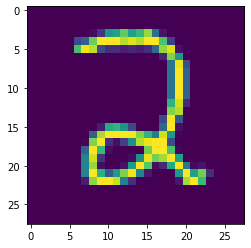

In [11]:
# example of one of the handwritten digits
plt.imshow(X[432].reshape((28,28)))

In [12]:
np.argmax(y[432])

2

In [13]:
# each image is 28x28 pixels, which is flattened
# out into an input array of length 784
len(X[0])

784

In [15]:
# instatiate network with sigmoid activation
# this shape returns an ~96% testing accuracy 
# and takes about 9min to train on the MNIST 
# dataset (60,000 images) on an intel pentium, 
# 8Gb memory
network = NeuralNetwork(
    shape=[784, 200, 80, 10], 
    activation = 'tanh', output_activation='sigmoid',
    loss="cross_entropy"
)

In [16]:
# verify that the forwad pass works and provides an 
# output with a probability for each label
guess = network.forward_pass(X[0])
guess

array([0.06307648, 0.17140734, 0.11572089, 0.06307925, 0.12527176,
       0.06311586, 0.06307638, 0.10072822, 0.17144746, 0.06307636])

In [17]:
# the position of the highest probability is taken
# to be the network's output
interpret = lambda x: np.argmax(x)
interpret(guess)

8

In [18]:
# verify that the backwards pass works
network.backward_pass(
    network_input = X[0],
    network_output = guess, 
    expected_output = y[0]
)

In [66]:
network_params = {
    'shape': [784, 200, 40, 10],
    'activation': 'sigmoid',
    'output_activation': 'sigmoid',
    'loss':'cross_entropy',
    'learning_rate': 0.001
}
network = NeuralNetwork(**network_params)
manager = NetworkManager(network)
with TqdmUpdate() as t: 
    training, testing = manager.train_test(X, y, mode="classify", progress=t.update_to)
    #training, testing = manager.kfold(X, y,k=10, split=0.2, mode="classify", progress=t.update_to)
 

100%|█████████▉| 13999/14000 [00:36<00:00, 384.56it/s]  


In [67]:
testing

{'precision': [0.9921208141825345,
  0.6195121951219512,
  0.8002735978112175,
  0.7007930785868781,
  0.10539018503620273,
  0.844043321299639,
  0.8647512263489839,
  0.4001473839351511,
  0.8018698309960446],
 'recall': [0.5813774528664871,
  0.8045248868778281,
  0.6331168831168831,
  0.8026424442609413,
  0.903448275862069,
  0.730625,
  0.7389221556886227,
  0.8165413533834587,
  0.7063668039277795],
 'accuracy': 0.7021428571428572,
 'fscore': 0.7121940309709873}

In [ ]:
# POSSIBLE IMPROVEMENTS: 
# 1. Implement Softmax output activation function. I have read that this 
#    performs better with classification problems since it normalizes the 
#    the output vector to have a norm of 1
# 3. Implement some sort of data set augmentation 
# 4. Implement some sort of convolution and pooling layers for faster computation
# 5. Implement adams optimizer for more efficient gradient descent
# 6. Research more on various error functions that can be used to evaluate the model. 